# Fine-Tuning DeepSeek-R1 with Chain-of-Thought for Automated MSc AI Admission Decisions

This notebook fine-tunes the DeepSeek-R1-Distill-LLaMA-8B model using chain-of-thought supervision to evaluate university transcripts and predict admission decisions (ACCEPT / REJECT / UNCLEAR). The system is trained to reason explicitly over formal admission regulations and is evaluated using schema compliance, coverage–accuracy trade-offs, and decision-level metrics before and after fine-tuning.

## Dependencies Install 

In [1]:
%%capture

!pip install unsloth
# Also get the latest nightly Unsloth!
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

!pip install --upgrade unsloth peft transformers torch

## Import Libraries

In [2]:
import os

from huggingface_hub import HfApi
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
import wandb

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import json
from datasets import Dataset

from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
from trl import SFTTrainer, SFTConfig 
import torch

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Setting Up

In [3]:
max_seq_length = 8192 
dtype = None 
load_in_4bit = True 

In [4]:
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
login(hf_token)

In [5]:
os.environ["WANDB_API_KEY"] = user_secrets.get_secret("WANDB_API_KEY")

run = wandb.init(
    project="fine-tune-deepseek-r1-distill-llama-8b-cot",
    job_type="training",
)

wandb: Currently logged in as: abdelrahman-elsisy (abdelrahman-elsisy-thws) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


## Loading Model & Tokenizer

In [6]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_token, 
)

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 5.0.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth: Will load unsloth/deepseek-r1-distill-llama-8b-unsloth-bnb-4bit as a legacy tokenizer.


## Loading & Processing The Train Dataset

In [7]:
with open('/kaggle/input/transcripts-cot-train/accepted_rejected.json', 'r', encoding='utf-8') as file:
    train_data = json.load(file)

n=10
print("Question:", train_data[n]['question'])
print("Response:", train_data[n]['answer'])

Question: You are a member of the admissions committee for the MSc Artificial Intelligence
program at THWS.
The  University Admission Regulations are as follows:
"""

Conditions for admission to the programme 

(1) Entitled to admission to the master's programme in Artificial Intelligence are persons who possess very good or good skills 
and knowledge in the area of computer science proven by a relevant practice- and theory-oriented qualification based on science. 

(2) 'The qualification referred to in (1) shall be attested by a degree of 210 credit points in accordance with the European Credit 
Transfer and Accumulation System (ECTS, hereinafter referred to as ECTS credits) and an overall grade of 2.5 or better completed at 
a German higher education institution in the field of computer science, or an equivalent degree. Of all required very good to good skills 
in mathematics and computer science (not less than 85% as a grade for the relevant modules), pplicants must in particular pr

In [11]:
# Convert to HuggingFace dataset and shuffle the  data
train_dataset = Dataset.from_list(train_data)
train_dataset = train_dataset.shuffle(seed=42)

print(f"Loaded {len(train_dataset)} samples")
print(train_dataset[0].keys())

Loaded 354 samples
dict_keys(['file_name', 'question', 'answer'])


In [12]:
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token  # Make sure tokenizer is already loaded

def formatting_prompts_train_func(examples):
    questions = examples["question"]
    answers = examples["answer"]
    texts = []
    
    for question, answer in zip(questions, answers):
        # Combine question (instruction) and answer (response with <think> tags)
        text = train_prompt_style.format(question, answer) + EOS_TOKEN
        texts.append(text)
    
    return {"text": texts}

In [13]:
train_dataset = train_dataset.map(formatting_prompts_train_func, batched=True) #, remove_columns=dataset.column_names)

print("Sample formatted text:")
print(train_dataset["text"][0][:500] + "...")

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

Sample formatted text:
Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a member of the admissions committee for the MSc Artificial Intelligence
program at THWS.
The  University Admission Regulations are as follows:
"""

Conditions for admission ...


In [14]:
all_lengths = []
for i in range(len(train_dataset)):
    length = len(tokenizer(train_dataset[i]["text"])['input_ids'])
    all_lengths.append(length)

print(f"Max length in entire dataset: {max(all_lengths)}")
print(f"Recommended max_seq_length: {max(all_lengths) + 100}")  # Add buffer

Max length in entire dataset: 7433
Recommended max_seq_length: 7533


## Model Inference Before Fine-Tuning

In [8]:
prompt_style = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, 
think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response. 
### Question:{}
### Response:<think>{}"""


In [9]:
question = train_data[50]['question']

FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=2048,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs)


In [10]:
print(response[0].split("### Response:")[1])

<think>
Okay, so I need to decide whether to accept, reject, or put this applicant in a borderline status based on the provided transcript and the university's admission regulations. Let's break this down step by step.

First, I should review the applicant's transcript. The university is Vel Tech Rangarajan Dr. Sagunthala R&D Institute of Science and Technology in Chennai, India. Since it's not a German university, the grading standards are different. The regulations mention that the admission is strict regarding grades and hours, especially if only one rule is not fulfilled, the applicant should be rejected.

Looking at the transcript, the applicant's name is DANNANA, and the overall CGPA is 8.78 out of 10. The grading scale used is a 10-point system where 'S' is the highest, followed by 'A', 'B', etc. The transcript also mentions that the grading system's exact grade/point mapping isn't specified, so I have to rely on the AI-generated mapping provided.

According to the AI-generated 

## Setting Up The Model

In [15]:
new_model = FastLanguageModel.get_peft_model(
    model,
    r=16,  
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,  
    bias="none",  
    use_gradient_checkpointing="unsloth",  # True or "unsloth" for very long context
    random_state=3407,
    use_rslora=False,  
    loftq_config=None,
)

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [16]:
# Initialize the finetune trainer
trainer = SFTTrainer(
    model = new_model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,

    # Training arguments
     args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs = 3,
        warmup_steps=5,
        learning_rate=2e-4,
        save_strategy="epoch",
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
    ),
    
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
[trl.trainer.sft_trainer|WARNING]You are using a per_device_train_batch_size of 1 with padding-free training. Using a batch size of 1 anihilate the benefits of padding-free training. Please consider increasing the batch size to at least 2.


Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/354 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


## Model Training

In [17]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 354 | Num Epochs = 3 | Total steps = 267
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Step,Training Loss
10,1.436963
20,1.168923
30,0.841893
40,0.632238
50,0.570575
60,0.572866
70,0.545805
80,0.513028
90,0.551371
100,0.475753


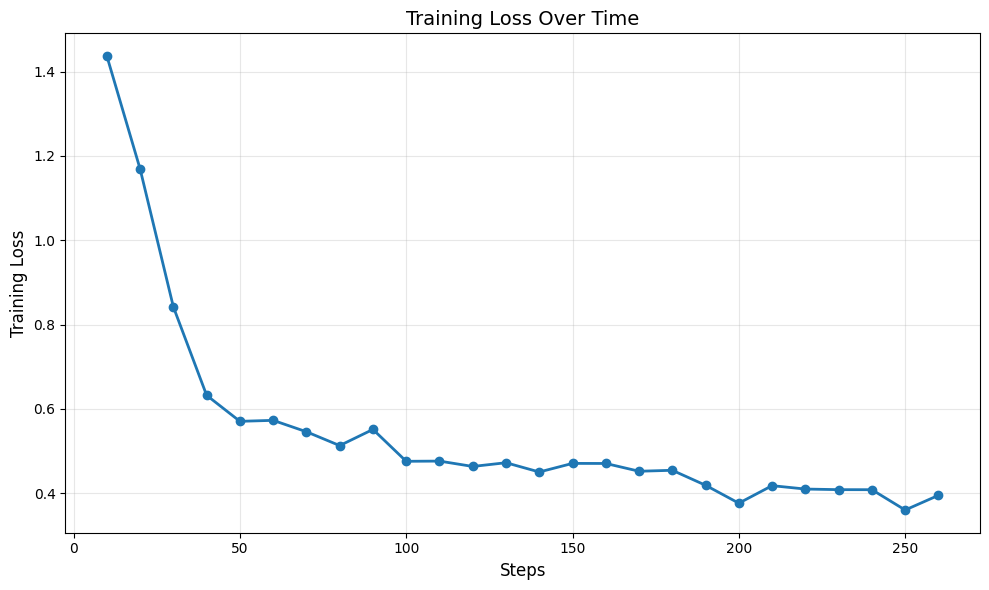

Initial loss: 1.4370
Final loss: 0.3950
Total reduction: 1.0420


In [20]:
# Extract loss values from training history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, marker='o', linewidth=2, markersize=6)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final loss
print(f"Initial loss: {train_loss[0]:.4f}")
print(f"Final loss: {train_loss[-1]:.4f}")
print(f"Total reduction: {train_loss[0] - train_loss[-1]:.4f}")

## Saving the model

In [21]:
wandb.finish()

In [26]:
checkpoint_path = "outputs/checkpoint-267"

# Push to Hugging Face
api = HfApi()
api.upload_folder(
    folder_path=checkpoint_path,
    repo_id="AbdoMorsi/deepseek-admission-cot",
    repo_type="model",
)

print("Model pushed to Hugging Face!")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.
[huggingface_hub.hf_api|WARNING]No files have been modified since last commit. Skipping to prevent empty commit.


Model pushed to Hugging Face!


## Loading & Processing The Test Dataset

In [8]:
with open('/kaggle/input/transcripts-test/test_transcripts.json', 'r', encoding='utf-8') as file:
    test_data = json.load(file)

In [9]:
test_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a member of the admissions committee for the MSc Artificial Intelligence\nprogram at THWS.
The  University Admission Regulations are as follows
[
Conditions for admission to the programme 
(1) Entitled to admission to the master's programme in Artificial Intelligence are persons who possess very good or good skills and knowledge in the area of computer science proven by a relevant practice- and theory-oriented qualification based on science. 
(2) 'The qualification referred to in (1) shall be attested by a degree of 210 credit points in accordance with the European Credit Transfer and Accumulation System (ECTS, hereinafter referred to as ECTS credits) and an overall grade of 2.5 or better completed at a German higher education institution in the field of computer science, or an equivalent degree. Of all required very good to good skills in mathematics and computer science (not less than 85% as a grade for the relevant modules), aplicants must in particular prove the following: 
    a) Advanced working programming knowledge (usually proven through work samples of programming projects, internships, or lab courses, and/or through the applicants' final thesis).
    b) At least 20 ECTS credits obtained in mathematics, in particular sufficient knowledge of statistics/probability theory, (linear) algebra, and analysis.
    c) At least 15 ECTS credits obtained in computer science, including sufficient knowledge of applied computer science (usually proven through courses on databases, operating systems, software engineering, or distributed systems) and of theoretical computer science (usually proven through courses on algorithms and data structures, automation theory, complexity theory, or logics). 
]
Here is the applicant Transcript that you have reviewed:
{}
Based on the above transcript and regulations, you should take on of three decisions: ACCEPT, REJECT, or UNCLEAR. If the university is not a German one, you should be so strict when it comes to the grades and hours (after converting them to German standards), if one and only one of the requirements is not fullfilled reject the application or at best put it as an UNCLEAR. If the transcript is on the borderline or if it doesn't contain any grades or courses, return UNCLEAR as a decision.

### Response:<think>"""

In [10]:
# Convert to HuggingFace dataset and shuffle the  data
test_dataset = Dataset.from_list(test_data)
test_dataset = test_dataset.shuffle(seed=42)

print(f"Loaded {len(test_dataset)} samples")
print(test_dataset[0].keys())

Loaded 170 samples
dict_keys(['file_name', 'transcript', 'true_label'])


In [11]:
def formatting_prompts_test_func(examples):
    transcripts = examples["transcript"]
    texts = []
    
    for transcript in transcripts:
        # Combine the transcripts to the question
        text = test_prompt_style.format(transcript)
        texts.append(text)
    
    return {"text": texts}

In [12]:
test_dataset = test_dataset.map(formatting_prompts_test_func, batched=True) #, remove_columns=dataset.column_names)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

In [13]:
print(test_dataset[0].keys())

dict_keys(['file_name', 'transcript', 'true_label', 'text'])


### Responses Generating Before Fine-Tuning

In [14]:
for n in range (len(test_data)):
    FastLanguageModel.for_inference(model) 
    question = test_dataset[n]['text']
    inputs = tokenizer(question, return_tensors="pt").to("cuda")
    
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=2048,
        use_cache=True,
    )
    response = tokenizer.batch_decode(outputs)
    test_data[n]["response_before_ft"] = response[0].split("### Response:")[1]
    
    try:
        if "accept" in test_data[n]["response_before_ft"].split("</think>")[1].lower():
            test_data[n]["predicted_label_before_ft"] = "accepted"
        elif "reject" in test_data[n]["response_before_ft"].split("</think>")[1].lower():
            test_data[n]["predicted_label_before_ft"] = "rejected"
        else:
            test_data[n]["predicted_label_before_ft"] = "unclear"
    except IndexError:
        test_data[n]["predicted_label_before_ft"] = "unclear"
        
    if (n%5==0) & (n>0):
        print(f"{n} applications processed")

5 applications processed
10 applications processed
15 applications processed
20 applications processed
25 applications processed
30 applications processed
35 applications processed
40 applications processed
45 applications processed
50 applications processed
55 applications processed
60 applications processed
65 applications processed
70 applications processed
75 applications processed
80 applications processed
85 applications processed
90 applications processed
95 applications processed
100 applications processed
105 applications processed
110 applications processed
115 applications processed
120 applications processed
125 applications processed
130 applications processed
135 applications processed
140 applications processed
145 applications processed
150 applications processed
155 applications processed
160 applications processed
165 applications processed


In [15]:
# Save the updated test data
output_path = 'test_transcripts_with_predictions_before_ft.json'

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(test_data, f, indent=2, ensure_ascii=False)

print(f"Test data saved to: {output_path}")

Test data saved to: test_data_with_predictions_before_ft.json


In [18]:
print(test_data[0].keys())

dict_keys(['file_name', 'transcript', 'true_label', 'response_before_ft', 'predicted_label_before_ft'])


### Responses Generating After Fine-Tuning

In [19]:
# reload the fine-tuned model

new_model, new_tokenizer = FastLanguageModel.from_pretrained(
    model_name="AbdoMorsi/deepseek-admission-cot",
    max_seq_length=8192,
    dtype=None,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(new_model)

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 5.0.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Unsloth: Will load unsloth/deepseek-r1-distill-llama-8b-unsloth-bnb-4bit as a legacy tokenizer.


adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

In [14]:
for n in range (len(test_data)):
    FastLanguageModel.for_inference(new_model) 
    question = test_dataset[n]['text']
    inputs = new_tokenizer(question, return_tensors="pt").to("cuda")
    
    outputs = new_model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=2048,
        use_cache=True,
    )
    response = new_tokenizer.batch_decode(outputs)
    test_data[n]["response_after_ft"] = response[0].split("### Response:")[1]
    
    try:
        if "accept" in test_data[n]["response_after_ft"].split("</think>")[1].lower():
            test_data[n]["predicted_label_after_ft"] = "accepted"
        elif "reject" in test_data[n]["response_after_ft"].split("</think>")[1].lower():
            test_data[n]["predicted_label_after_ft"] = "rejected"
        else:
            test_data[n]["predicted_label_after_ft"] = "unclear"
    except IndexError:
        test_data[n]["predicted_label_after_ft"] = "unclear"
        
    if (n%5==0) & (n>0):
        print(f"{n} applications processed")

5 applications processed
10 applications processed
15 applications processed
20 applications processed
25 applications processed
30 applications processed
35 applications processed
40 applications processed
45 applications processed
50 applications processed
55 applications processed
60 applications processed
65 applications processed
70 applications processed
75 applications processed
80 applications processed
85 applications processed
90 applications processed
95 applications processed
100 applications processed
105 applications processed
110 applications processed
115 applications processed
120 applications processed
125 applications processed
130 applications processed
135 applications processed
140 applications processed
145 applications processed
150 applications processed
155 applications processed
160 applications processed
165 applications processed


In [21]:
# Save the updated test data
output_path = 'test_transcripts_with_predictions_after_ft.json'

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(test_data, f, indent=2, ensure_ascii=False)

print(f"Test data saved to: {output_path}")

Test data saved to: test_transcripts_with_predictions_after_ft.json


In [22]:
print(test_data[1].keys())

dict_keys(['file_name', 'transcript', 'true_label', 'response_before_ft', 'predicted_label_before_ft', 'response_after_ft', 'predicted_label_after_ft'])


## Evaluation

In [24]:
with open('/kaggle/input/transcripts-test/test_transcripts_with_predictions_after_ft.json', 'r', encoding='utf-8') as file:
    test_data = json.load(file)

In [25]:
# Convert to pandas df
df = pd.DataFrame(test_data)

In [26]:
# Setting a style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 11

### Response Structure Evaluation

In [27]:
EXPECTED_SECTIONS = [
    "Degree Requirements Check",
    "Programming Knowledge Assessment",
    "Mathematics Requirements",
    "Computer Science Requirements",
    "Overall Grade Assessment",
    "Final Decision Justification"
]


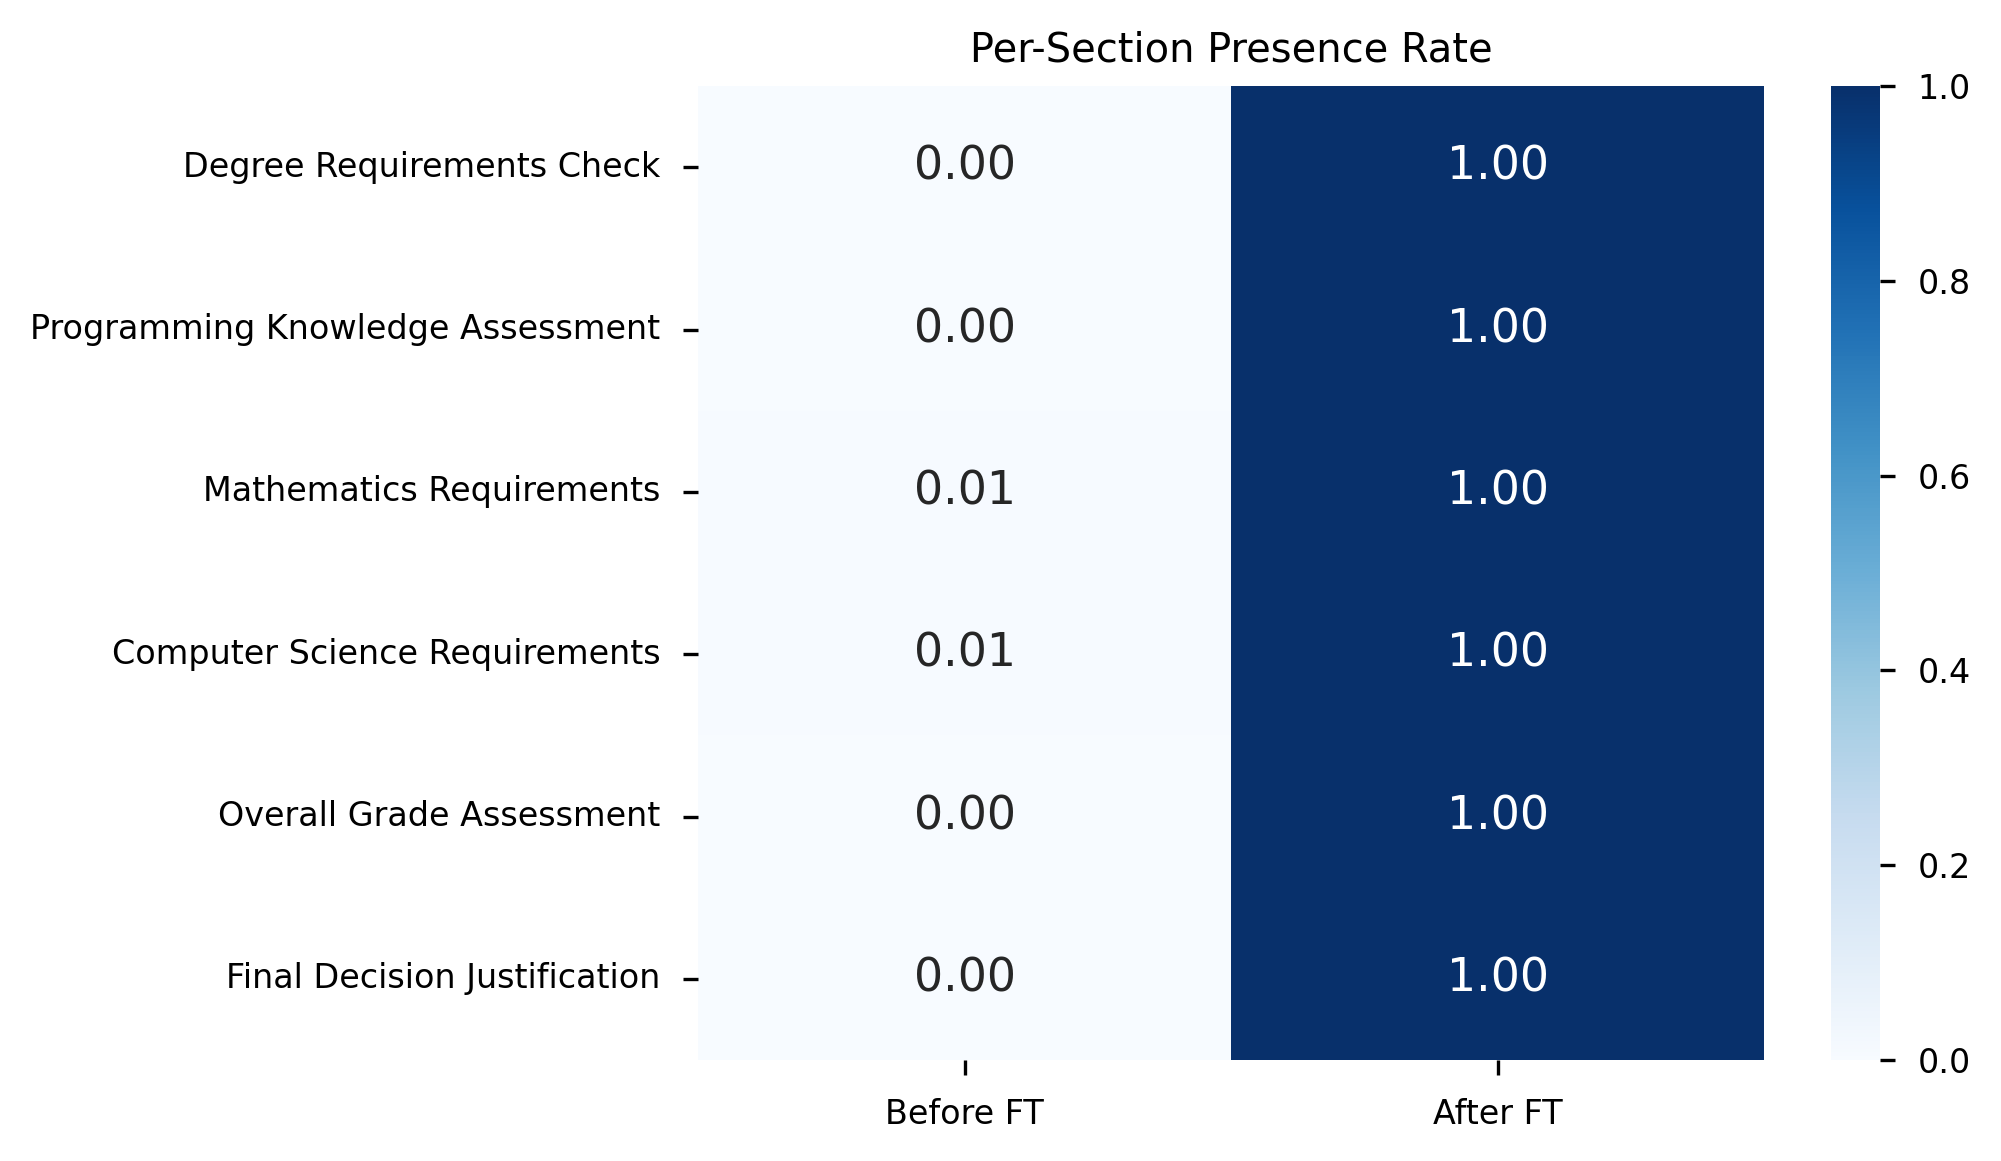

In [28]:
def section_presence(text):
    text_lower = text.lower()
    return {
        section: int(section.lower() in text_lower)
        for section in EXPECTED_SECTIONS
    }

presence_before = df["response_before_ft"].apply(section_presence).apply(pd.Series)
presence_after  = df["response_after_ft"].apply(section_presence).apply(pd.Series)

presence_rate = pd.DataFrame({
    "Before FT": presence_before.mean(),
    "After FT": presence_after.mean()
})


plt.figure(figsize=(7,4))
sns.heatmap(
    presence_rate,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)
plt.title("Per-Section Presence Rate")
plt.tight_layout()
plt.show()


### Final Label Evaluation

In [29]:
# True label distribution
print("\n1. True Label Distribution:")
print(df['true_label'].value_counts())

# Predicted label distributions
print("\n2. Predicted Labels - Before Fine-tuning:")
print(df['predicted_label_before_ft'].value_counts())

print("\n3. Predicted Labels - After Fine-tuning:")
print(df['predicted_label_after_ft'].value_counts())


1. True Label Distribution:
true_label
rejected    85
accepted    85
Name: count, dtype: int64

2. Predicted Labels - Before Fine-tuning:
predicted_label_before_ft
accepted    75
unclear     49
rejected    46
Name: count, dtype: int64

3. Predicted Labels - After Fine-tuning:
predicted_label_after_ft
accepted    86
rejected    84
Name: count, dtype: int64


In [30]:
TRUE_LABELS = ["accepted", "rejected"]
PRED_LABELS = ["accepted", "rejected", "unclear"]

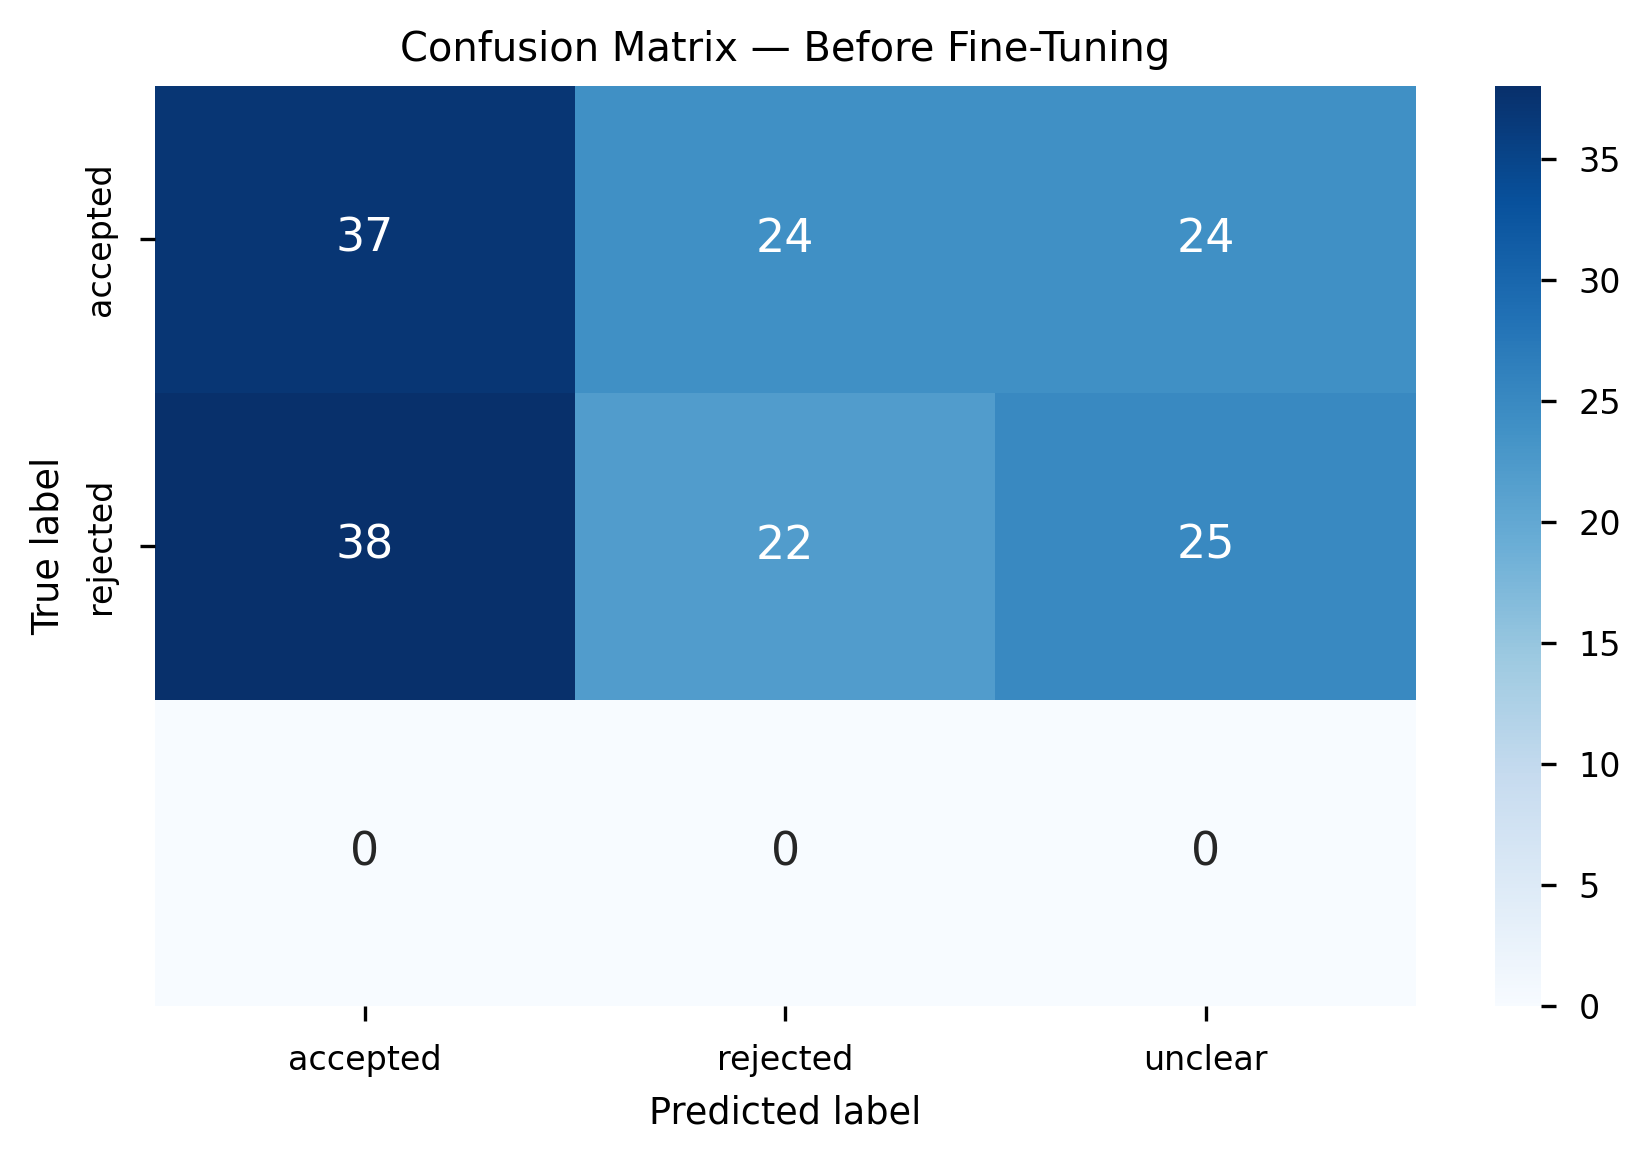

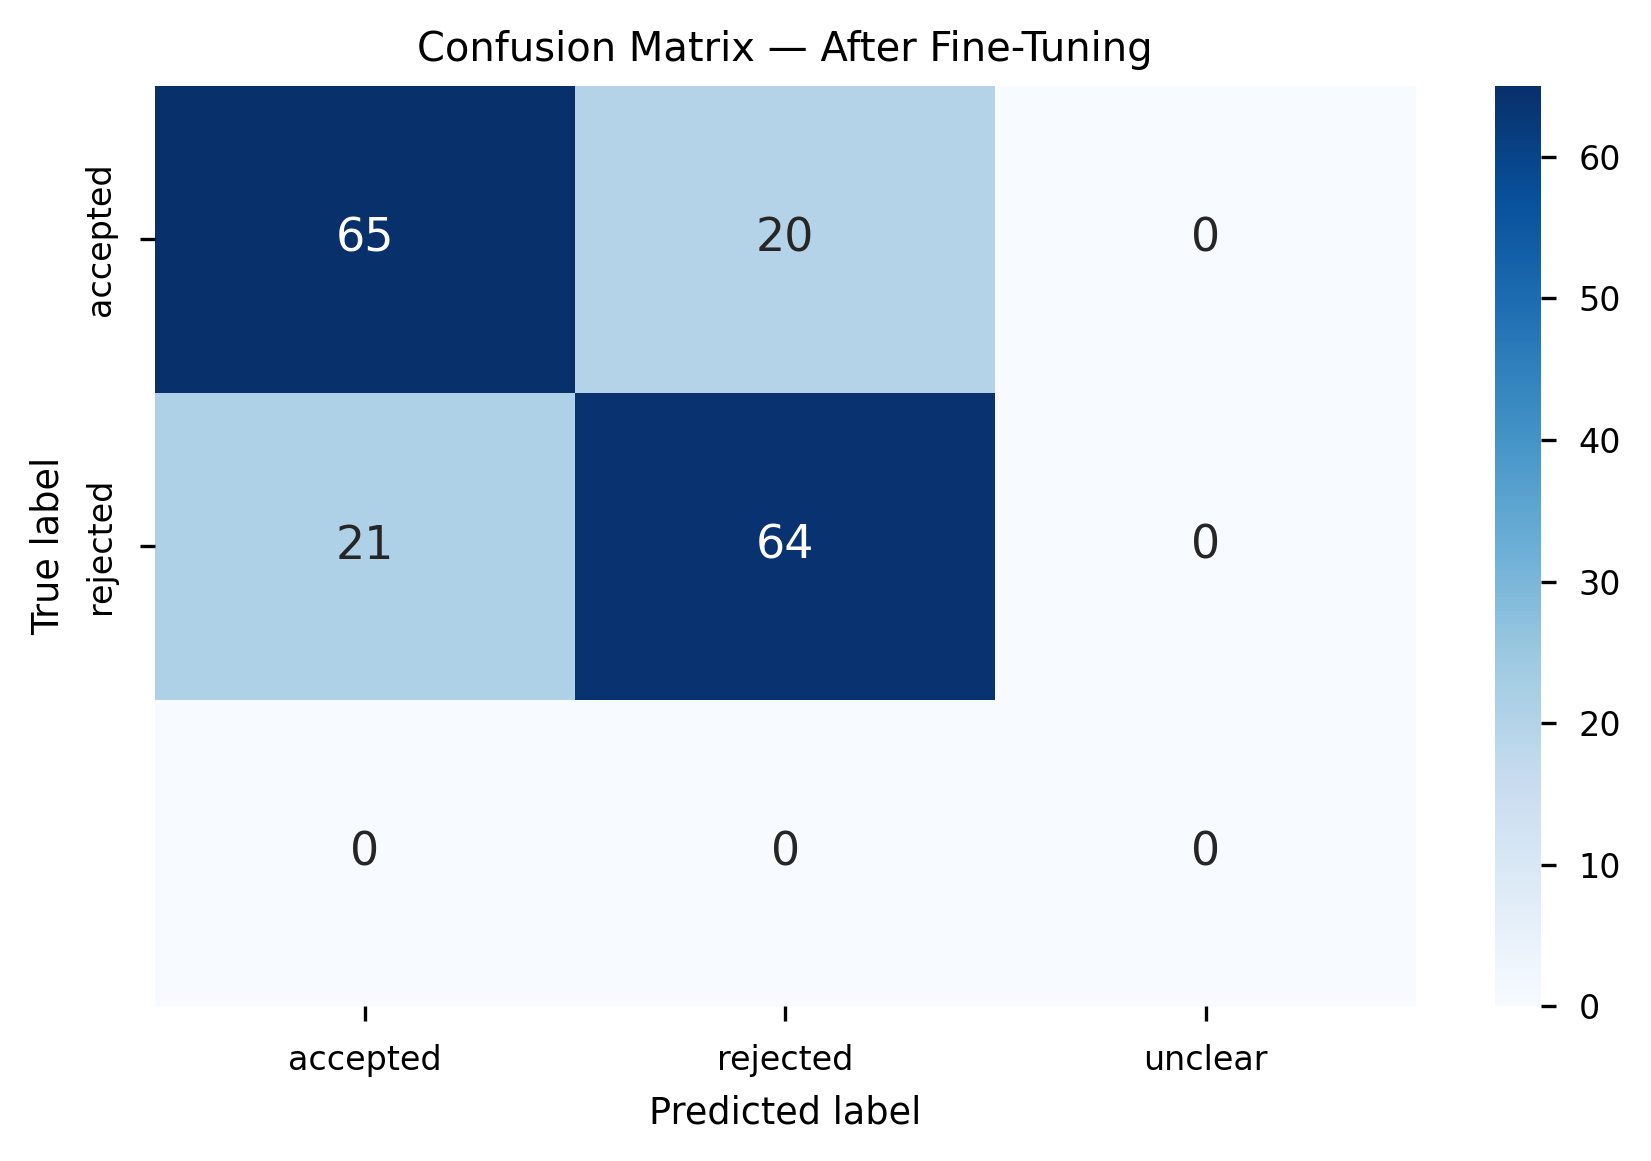

In [31]:
def plot_confusion(true, pred, title):
    cm = confusion_matrix(true, pred, labels=PRED_LABELS)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=PRED_LABELS,
        yticklabels=TRUE_LABELS
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(
    df["true_label"],
    df["predicted_label_before_ft"],
    "Confusion Matrix — Before Fine-Tuning"
)

plot_confusion(
    df["true_label"],
    df["predicted_label_after_ft"],
    "Confusion Matrix — After Fine-Tuning"
)

/tmp/ipykernel_55/2229086430.py:3: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)


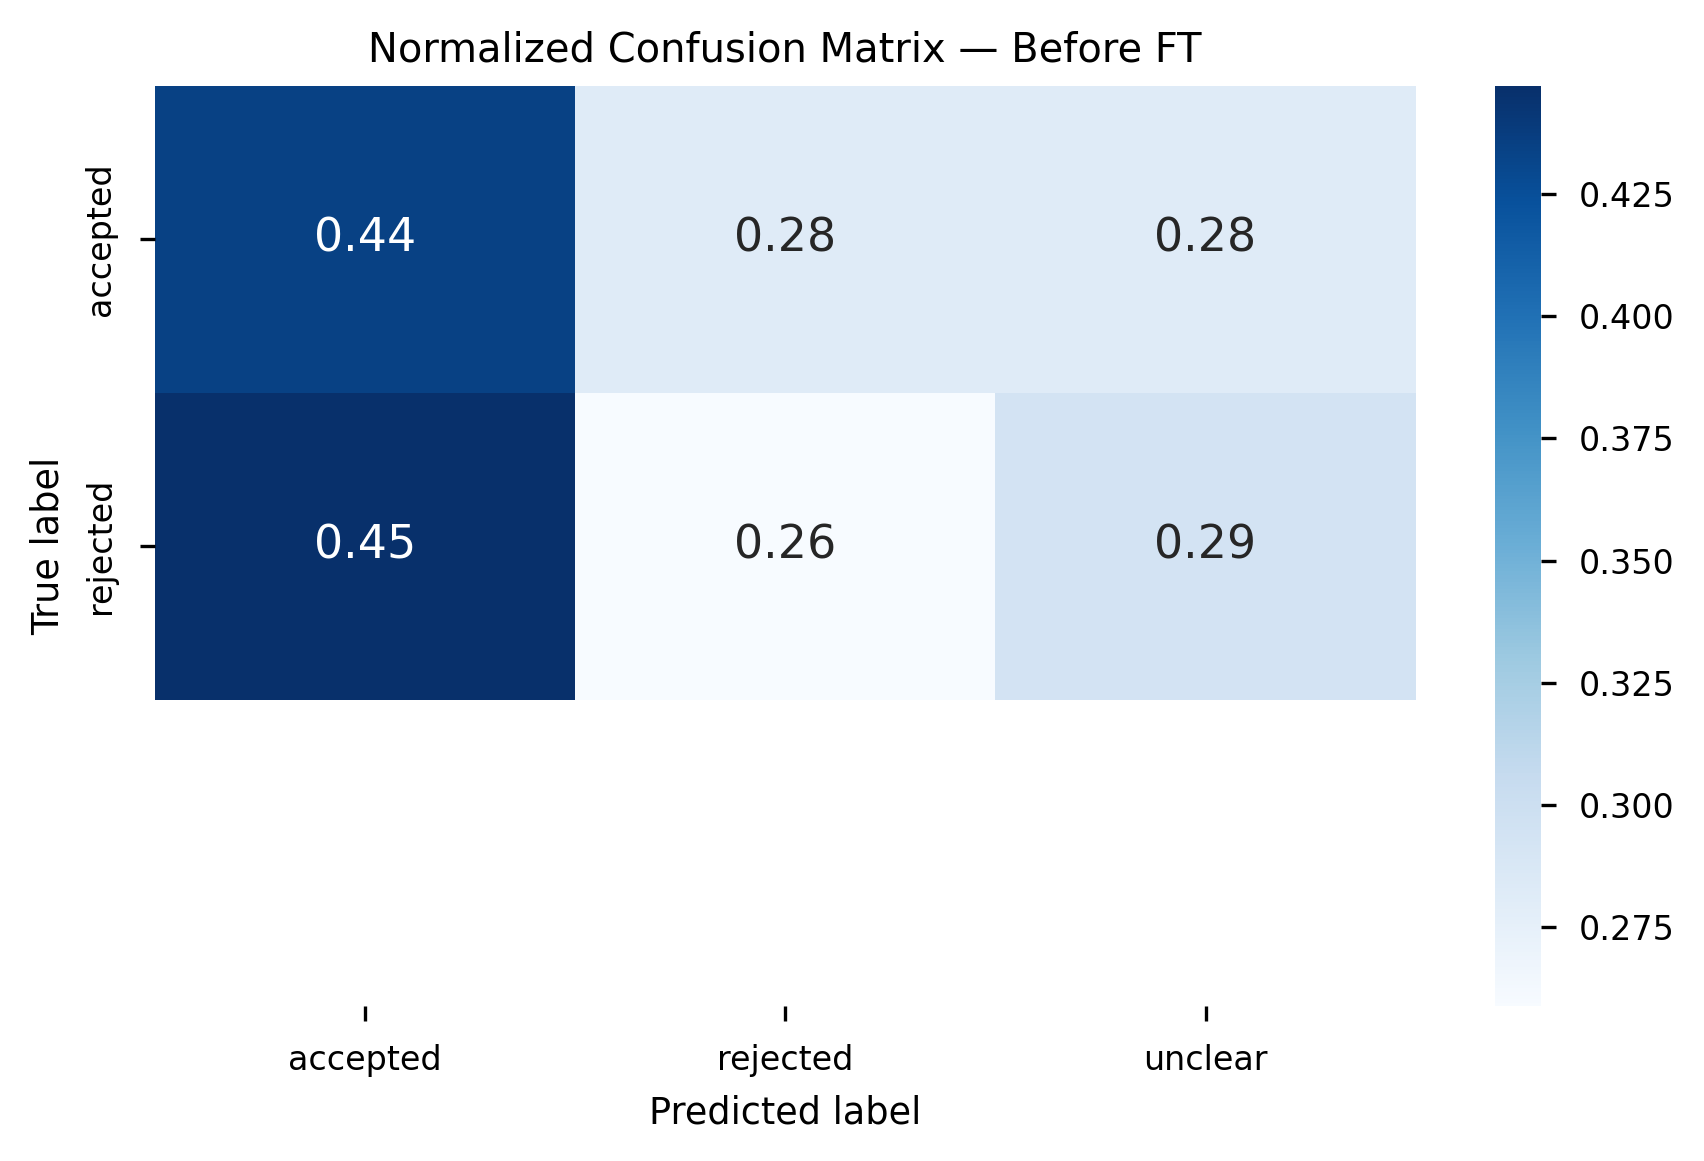

/tmp/ipykernel_55/2229086430.py:3: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)


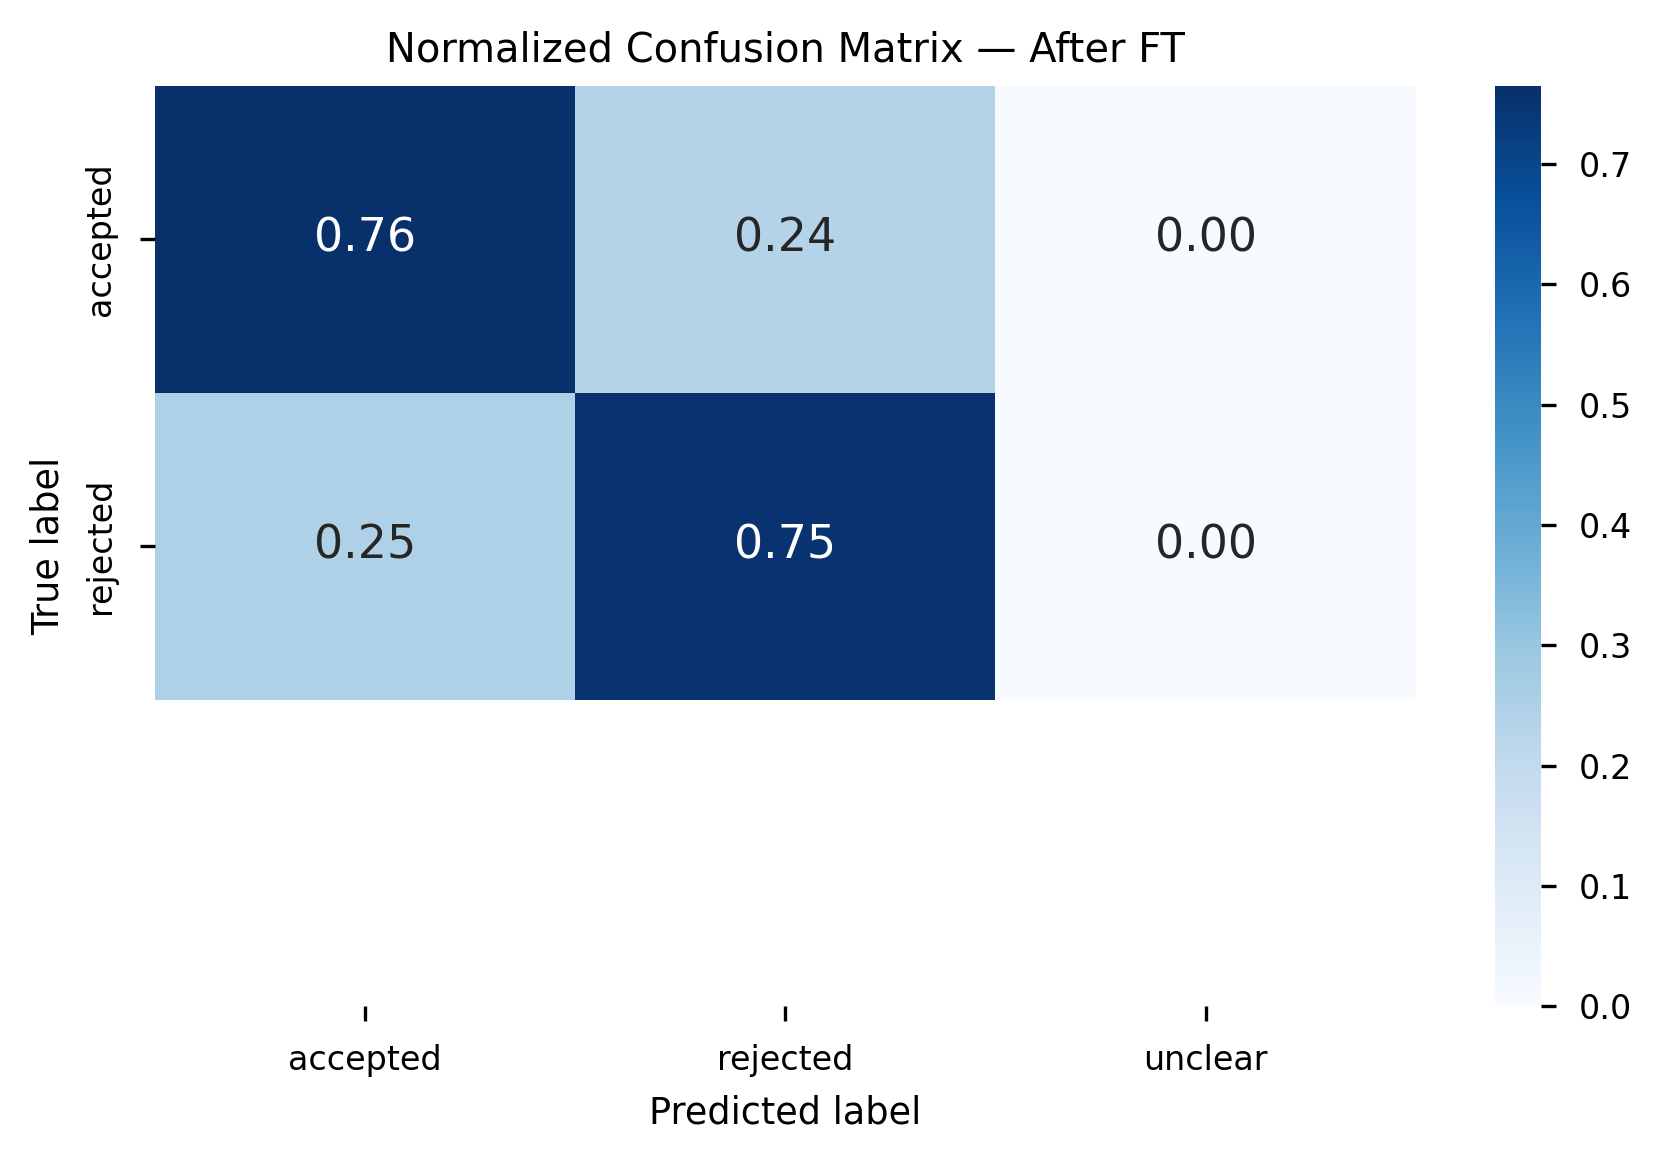

In [32]:
def plot_confusion_normalized(true, pred, title):
    cm = confusion_matrix(true, pred, labels=PRED_LABELS)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=PRED_LABELS,
        yticklabels=TRUE_LABELS
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_normalized(
    df["true_label"],
    df["predicted_label_before_ft"],
    "Normalized Confusion Matrix — Before FT"
)

plot_confusion_normalized(
    df["true_label"],
    df["predicted_label_after_ft"],
    "Normalized Confusion Matrix — After FT"
)


In [33]:
def unclear_rate(series):
    return (series == "unclear").mean()

rates = pd.DataFrame({
    "Before FT": [unclear_rate(df["predicted_label_before_ft"])],
    "After FT": [unclear_rate(df["predicted_label_after_ft"])]
}, index=["Unclear rate"])

rates

,Before FT,After FT
Unclear rate,0.288235,0.0


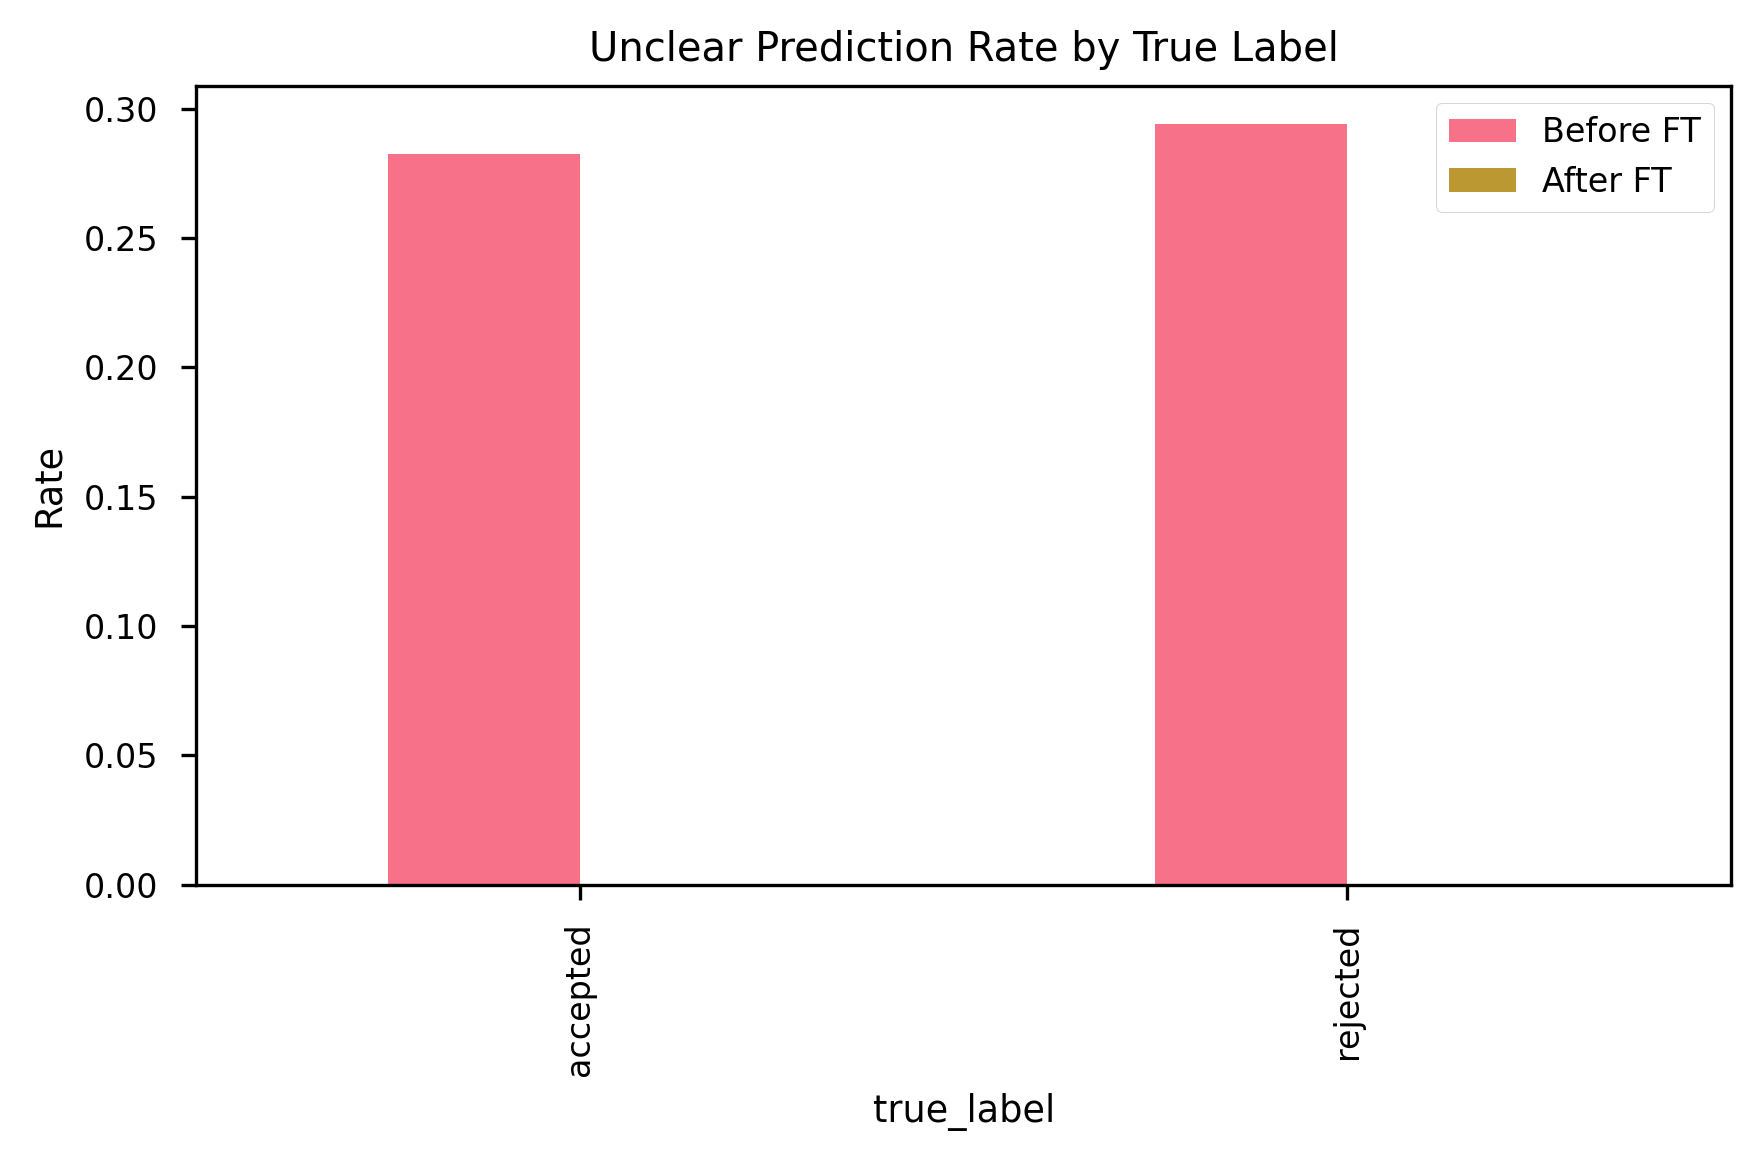

In [34]:
def unclear_by_true(pred_col):
    return (
        df.assign(is_unclear=df[pred_col] == "unclear")
          .groupby("true_label")["is_unclear"]
          .mean()
    )

unclear_df = pd.DataFrame({
    "Before FT": unclear_by_true("predicted_label_before_ft"),
    "After FT": unclear_by_true("predicted_label_after_ft")
})

unclear_df.plot(kind="bar", figsize=(6,4))
plt.ylabel("Rate")
plt.title("Unclear Prediction Rate by True Label")
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import classification_report

filtered = df[df["predicted_label_before_ft"] != "unclear"]

print(classification_report(
    filtered["true_label"],
    filtered["predicted_label_before_ft"],
    target_names=["accepted", "rejected"]
))

              precision    recall  f1-score   support

    accepted       0.49      0.61      0.54        61
    rejected       0.48      0.37      0.42        60

    accuracy                           0.49       121
   macro avg       0.49      0.49      0.48       121
weighted avg       0.49      0.49      0.48       121



In [36]:
filtered = df[df["predicted_label_after_ft"] != "unclear"]

print(classification_report(
    filtered["true_label"],
    filtered["predicted_label_after_ft"],
    target_names=["accepted", "rejected"]
))

              precision    recall  f1-score   support

    accepted       0.76      0.76      0.76        85
    rejected       0.76      0.75      0.76        85

    accuracy                           0.76       170
   macro avg       0.76      0.76      0.76       170
weighted avg       0.76      0.76      0.76       170



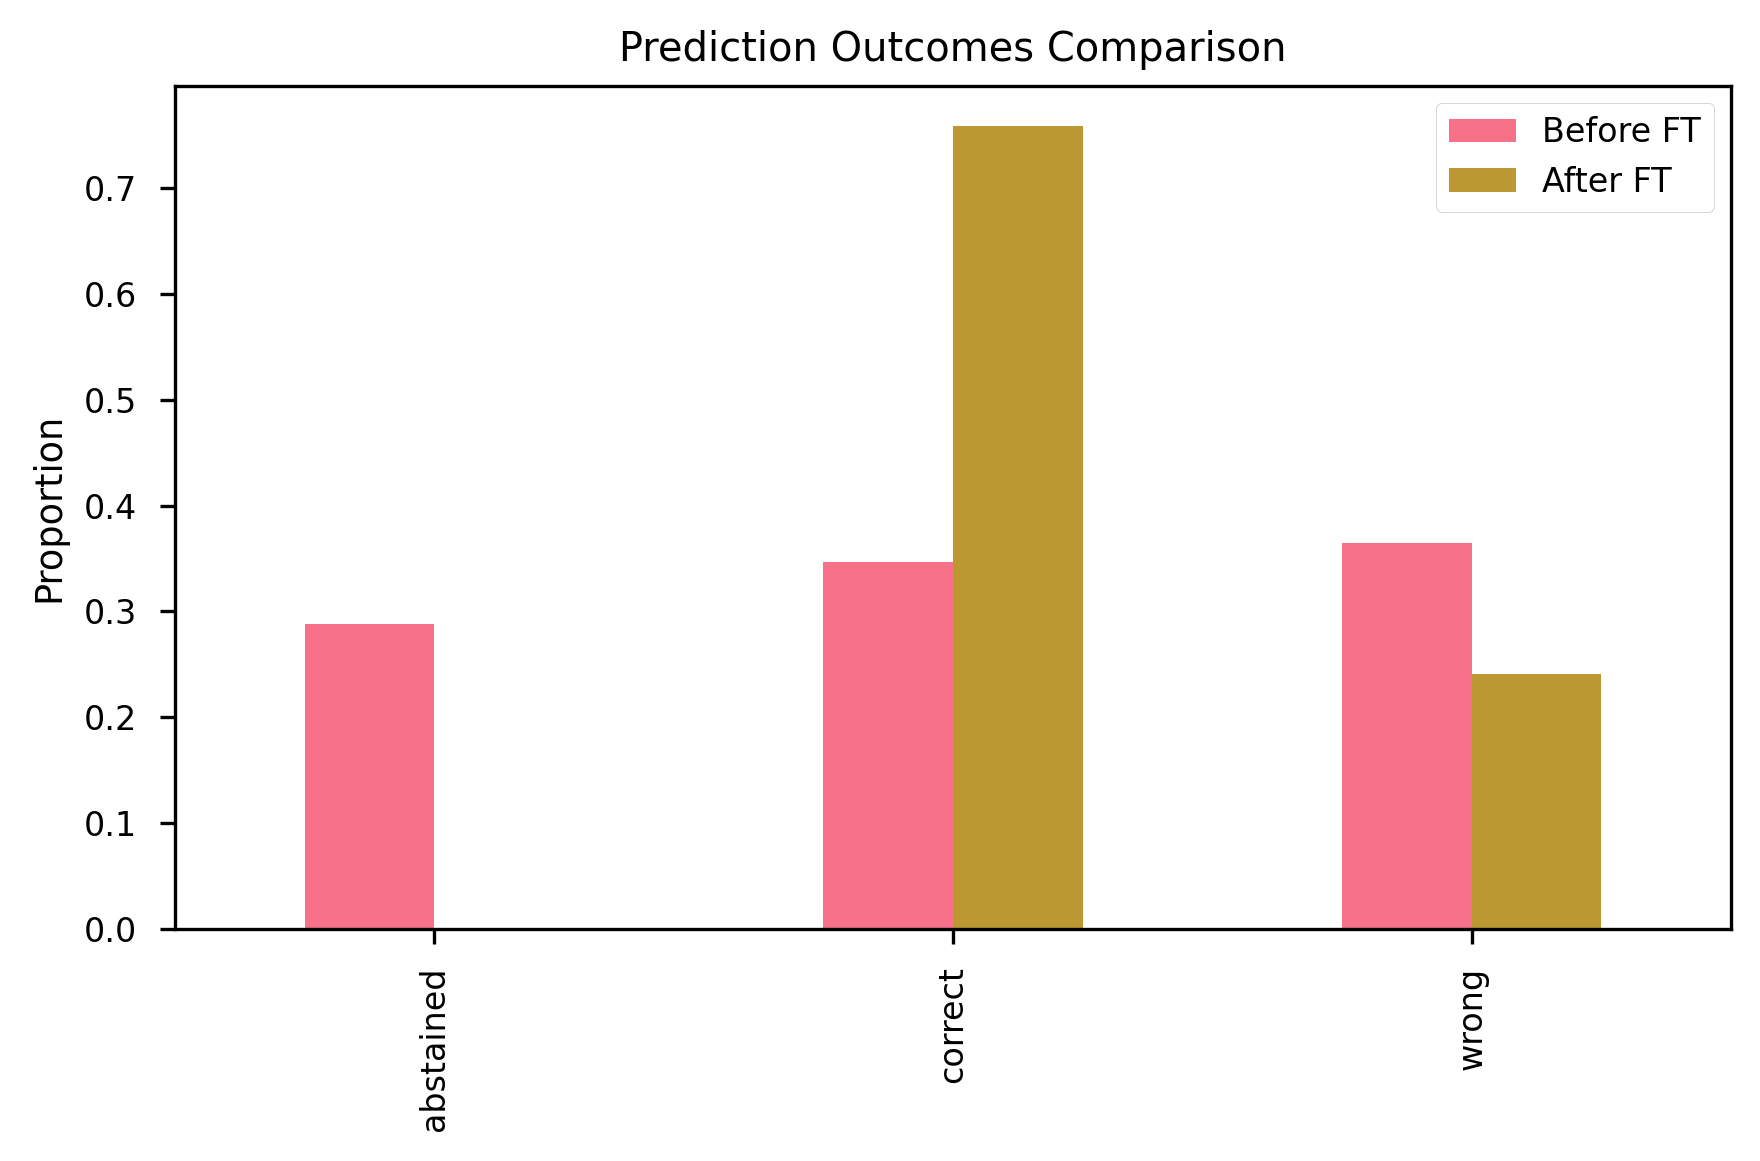

In [37]:
def outcome(true, pred):
    if pred == "unclear":
        return "abstained"
    elif true == pred:
        return "correct"
    else:
        return "wrong"

df["outcome_before"] = [
    outcome(t, p) for t, p in zip(df["true_label"], df["predicted_label_before_ft"])
]

df["outcome_after"] = [
    outcome(t, p) for t, p in zip(df["true_label"], df["predicted_label_after_ft"])
]

outcome_counts = pd.DataFrame({
    "Before FT": df["outcome_before"].value_counts(normalize=True),
    "After FT": df["outcome_after"].value_counts(normalize=True)
})

outcome_counts.plot(kind="bar", figsize=(6,4))
plt.ylabel("Proportion")
plt.title("Prediction Outcomes Comparison")
plt.tight_layout()
plt.show()